In [1]:
import pandas as pd
import numpy as np
np.seterr(all="raise")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
df = pd.read_parquet("out/2019-11-06-2d-train.parquet")
print(len(df))

i = df.direct_time < 0
assert i.sum() == 22
df = df[~i]

i = df.fft_time <= 0
assert i.sum() == 38
df = df[~i]

11700


In [3]:
df["h_nelement"] = df["h.shape[0]"] * df["h.shape[1]"]
df["x_nelement"] = df["x.shape[0]"] * df["x.shape[1]"]
df["log10(fft_time/direct_time)"] = np.log10(df.fft_time / df.direct_time)
df["fft_time/direct_time"] = df.fft_time / df.direct_time
df.tail()

,fft_time,direct_time,mode,x.shape[0],x.shape[1],h.shape[0],h.shape[1],random_state,h_nelement,x_nelement,log10(fft_time/direct_time),fft_time/direct_time
11695,0.004606,0.576664,valid,313,467,7,30,11695,210,146171,-2.097621,0.007987
11696,0.016217,161.345037,same,467,193,313,356,11696,111428,90131,-3.997792,0.000101
11697,0.000653,0.351569,full,467,23,335,3,11697,1005,10741,-2.731395,0.001856
11698,0.005768,2.494669,valid,335,467,8,146,11698,1168,156445,-2.636019,0.002312
11699,0.016461,154.696508,same,467,370,335,146,11699,48910,172790,-3.973027,0.000106


In [4]:
df.fft_time.max()

0.06071734428405762

In [5]:
df.direct_time.max()

1639.7271144390106

# Visualize ratio

Text(0.5, 1, 'valid')

Text(0.5, 1, 'same')

Text(0.5, 1, 'full')

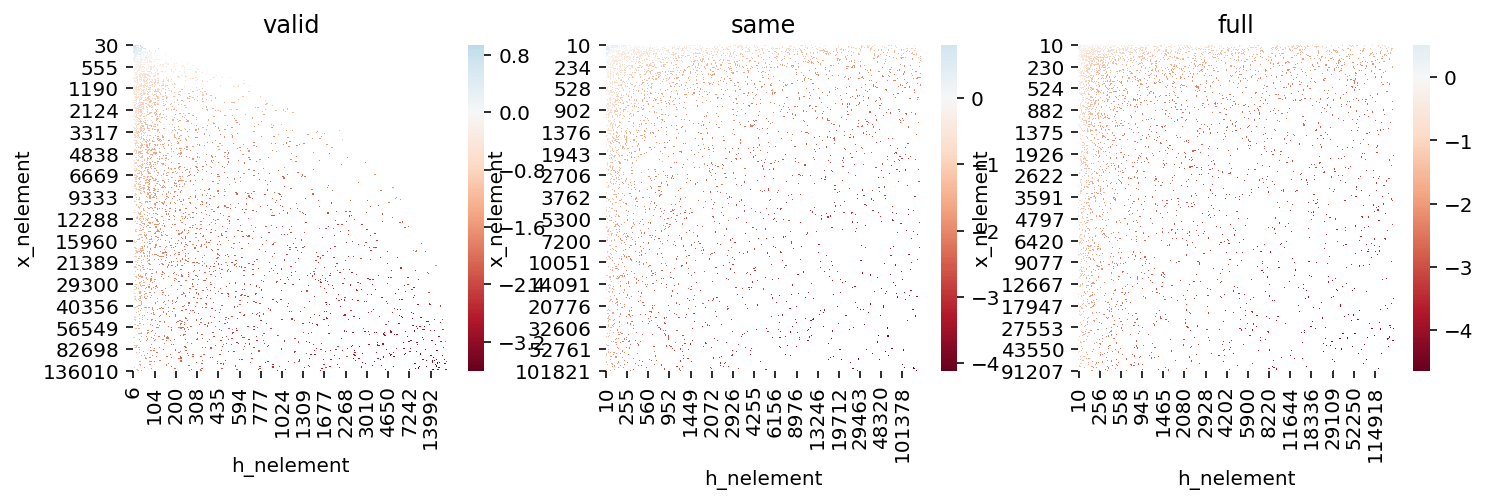

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

w = 3
fig, axs = plt.subplots(ncols=3, figsize=(4 * w, w))
for ax, mode in zip(axs, ["valid", "same", "full"]):
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    show = df[df["mode"] == mode].pivot_table(
        index="x_nelement",
        columns="h_nelement",
        values="log10(fft_time/direct_time)",
    )
    ax = sns.heatmap(
        show,
        center=0,
        ax=ax,
        cmap="RdBu",
    )
    ax.set_title(mode)

# Find big-O constant

``` python
fft, direct = times(O_fft, O_direct)
method = "fft" if fft * O_fft < direct * O_direct else "direct"
```

Use torch to code custom loss function.


In [7]:
import sys
sys.path.append("..")
from common import _prod, _fftconv_faster

In [10]:
from scipy.optimize import curve_fit
from toolz import partial
sum_builtin = sum

def log_time(shapes, O, mode, out="fft", O_offset=None):
# def _fftconv_faster(shapes, O, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    ops = []
    for shape in shapes:
        x_shape = shape[:2]
        h_shape = shape[2:]
        assert len(shape) == 4
        assert len(x_shape) == len(h_shape) == 2
        fft_op, direct_op = _fftconv_faster(
            x_shape, h_shape, mode,
        )
        ops.append([fft_op, direct_op])
    ops = np.asarray(ops)
    fft_op = ops[:, 0]
    direct_op = ops[:, 1]
    
    if out == "direct":
        return np.log2(O * direct_op + O_offset)
    elif out == "fft":
        return np.log2(O * fft_op)
    raise ValueError("out misspecified")

def get_constant(df, mode):
    """
    Inputs
    ------
    df : DataFrame with columns x.shape[0], x.shape[1], h.shape[0], h.shape[1] and log10(fft_time/direct_time)
    
    Returns
    -------
    popt : float
        The constant such that constant * fft_time < direct_time
    pstd : float
        The (estimated) standard deviation of popt
    """
    shapes = df[["x.shape[0]", "x.shape[1]", "h.shape[0]", "h.shape[1]"]].values
    kwargs = {"bounds": (1e-10, 1e-4), "p0": 1e-5, "method": "dogbox", "ftol": None, "gtol": None}
    
    O_offset = -3e-5
    times = np.log2(df["fft_time"].values)
#     times = df["fft_time"].values
    log_time_w_mode = partial(log_time, mode=mode, out="fft", O_offset=O_offset)
    popt, pcov = curve_fit(log_time_w_mode, shapes, times, **kwargs)
    O_fft = popt.item()
    
    log_time_w_mode = partial(log_time, mode=mode, out="direct", O_offset=O_offset)
    times = np.log2(df["direct_time"].values)
#     times = df["direct_time"].values
    popt, pcov = curve_fit(log_time_w_mode, shapes, times, **kwargs)
    O_direct = popt.item()
    return (O_fft, O_direct, O_offset), -1

In [11]:
from pprint import pprint
bigOs = []
for mode in ["same", "valid", "full"]:
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    fit = df[idx].copy()
    (O_fft, O_direct, O_offset), err = get_constant(fit, mode)
    bigOs.append({"O_fft": O_fft, "O_direct": O_direct, "O_offset": O_offset,
                   "mode": mode})
    pprint(bigOs[-1])


FloatingPointError: invalid value encountered in log2

In [ ]:
constants = pd.DataFrame(bigOs)
constants["ndim"] = 2

In [ ]:
constants

In [ ]:
# constants["std"] / constants["constant"]

In [ ]:
constants.to_csv("constants.csv")

In [ ]:
len(df)

In [ ]:
df.columns

In [ ]:
s[~nan]

In [ ]:
s = df.copy()
s.sort_values(by="direct_time", inplace=True)

def log_bin(x, decimals=0):
    return 2 ** np.round(np.log2(x), decimals=decimals)

for key in ["direct_time", "x_nelement", "h_nelement"]:
    s[key + "_binned"] = log_bin(s[key])

import seaborn as sns


w = 5
fig, ax = plt.subplots(figsize=(w, w))
for mode in ["full", "same", "valid"]:
    _s = s[s["mode"] == mode].copy()
    td = _s["direct_time"].min()
    tf = _s["fft_time"].min()
    print(td - td)
    _s.sort_values(by="direct_time", inplace=True)
    ax.plot(_s.x_nelement, _s.direct_time.values, "o", alpha=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(alpha=0.4, which="both")
ax.set_ylim(10**-5, None)